In [299]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import *
import matplotlib.pyplot as plt

In [300]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [301]:
#formato de las imágenes
img_width, img_height = 48,48

In [302]:
train_data_dir ='C:/Users/mmaccari/images/images/train'
validation_data_dir ='C:/Users/mmaccari/images/images/validation'
nb_train_samples = 28821
nb_validation_samples = 7066
epochs = 100
batch_size = 32 #cant de imagenes que pasan por la red neuronal antes de actualizar los pesos
kernel_size = 3
pool_size = 2
num_classes = 7

In [261]:
#3 si las imágenes son a color, 1 si las imágenes son blanco y negro
if K.image_data_format() == 'channels_first':
 input_shape = (3, img_width, img_height)
else:
 input_shape = (img_width, img_height, 3)

Tamaño de filtro: cuántos mapas de caracteristicas quiero crear. filters 32 detectors en la primera capa(32,3,3)
Kernel size: tamaño de cada uno de los filtros(3,3) tamaño de las ventanas
padding: gestionar si la ventana esta centrada en un pixel o desplazada hacia la izq o derecha. Same=centrado
input shape: filas, columnas, color o blanco y negro
Funcion de activacion: relu para eliminar pixeles negativos

In [303]:
model = Sequential()

#Primera capa oculta de 32 filtros, kernel de 3x3 y poolsize de 2x2
#capa de convolucion
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))

#capa de max pooling(me quedo con el valor máximo, los mapas de caracteristicas se reducen)
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),))
model.add(Dropout(0.2))

#Segunda capa oculta de 64 filtros, kernel de 3x3 
model.add(Conv2D(64, (kernel_size, kernel_size),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))#poolsize de 2x2 (tamaño de la ventana que se aplica, matriz 2*2)
model.add(Dropout(0.2))

#Tercera capa oculta de 128 filtros, kernel de 3x3 y poolsize de 2x2
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.2))

#Flattening, aplanar los datos a un vector vertical, los mapas de caracteristicas se aplanan,será la entrada a la red neuronal.
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))

#red neuronal totalmente conectada, full connection
model.add(Dense(128)) #son los nodos 
model.add(Activation('relu'))
model.add(Dropout(0.5))

#red neuronal totalmente conectada, full connection
model.add(Dense(64)) #son los nodos 
model.add(Activation('relu'))
model.add(Dropout(0.5))

#capa de salida, funcion de activacion sigmoid. Probabilidad de clases=7
model.add(Dense(7))
model.add(Activation('softmax'))
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_66 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_67 (Activation)   (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 12, 12, 64)      

In [304]:
model.compile(loss='categorical_crossentropy',
 optimizer=Adam(lr=0.001),
 metrics=['accuracy'])

In [305]:
#Preproceso, rotaciones, cambios de escala (0 a 1), zoom. Incrementar la cantidad de imágenes.
train_datagen = ImageDataGenerator(
 rescale=1. / 255,
 shear_range=0.2,
 zoom_range=0.2,#Rango para zoom aleatorio
 horizontal_flip=True)#Voltea aleatoriamente las entradas horizontalmente.

In [306]:
#Valores de 0 a 1
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [307]:
#training dataset
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
color_mode="grayscale",
batch_size=batch_size,
class_mode='categorical') #7 clases

#validation dataset
validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size=(img_width, img_height),
color_mode="grayscale",
batch_size=batch_size,
class_mode='categorical', 
shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In [308]:
# Para guardar el modelo que ha dado mejor rendimiento. Supervisa la pérdida total del modelo ("val_loss")
checkpoint = ModelCheckpoint('analisis_emociones_faciales.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=3)

# Dejar de entrenar cuando una métrica monitoreada haya dejado de mejorar. Patience: luego de 20 epocas sin mejora deja de entrenar
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=3,
                          restore_best_weights=True
                          )

#Reducir la tasa de aprendizaje cuando una métrica haya dejado de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=3,
                              min_delta=0.0001)

callbacks = [checkpoint] #[earlystop,checkpoint,reduce_lr]

Accuracy: precision. Porcentaje de aciertos
Loss: pérdida. Mide el error entre la salida predicha y la salida deseada.

Loss y accuracy son los resultados sobre el conj de train.
Val_loss y val_accuracy(deberia superar 0,80) son los resultados sobre el conj de testing 

In [309]:
#Entrenar el modelo
history=model.fit_generator(
     train_generator,
     steps_per_epoch=nb_train_samples // batch_size, #conjunto de train. quitar batch_size???
     epochs=epochs,
    callbacks=callbacks,
     validation_data=validation_generator,
     validation_steps=nb_validation_samples // batch_size)#conjunto de validacion


Epoch 1/100
900/900 [==============================] - 177s 196ms/step - loss: 1.8293 - accuracy: 0.2433 - val_loss: 1.9644 - val_accuracy: 0.2594

Epoch 00001: val_loss improved from inf to 1.96437, saving model to analisis_emociones_faciales.h5.h5
Epoch 2/100
900/900 [==============================] - 174s 193ms/step - loss: 1.7996 - accuracy: 0.2510 - val_loss: 1.8123 - val_accuracy: 0.2775

Epoch 00002: val_loss improved from 1.96437 to 1.81229, saving model to analisis_emociones_faciales.h5.h5
Epoch 3/100
900/900 [==============================] - 187s 208ms/step - loss: 1.7809 - accuracy: 0.2602 - val_loss: 1.7604 - val_accuracy: 0.2967

Epoch 00003: val_loss improved from 1.81229 to 1.76040, saving model to analisis_emociones_faciales.h5.h5
Epoch 4/100
900/900 [==============================] - 160s 178ms/step - loss: 1.7416 - accuracy: 0.2818 - val_loss: 1.7533 - val_accuracy: 0.3129

Epoch 00004: val_loss improved from 1.76040 to 1.75327, saving model to analisis_emociones_fac

900/900 [==============================] - 143s 159ms/step - loss: 1.4236 - accuracy: 0.4570 - val_loss: 1.4082 - val_accuracy: 0.5215

Epoch 00040: val_loss did not improve from 0.88698
Epoch 41/100
900/900 [==============================] - 154s 171ms/step - loss: 1.4204 - accuracy: 0.4588 - val_loss: 1.5032 - val_accuracy: 0.5226

Epoch 00041: val_loss did not improve from 0.88698
Epoch 42/100
900/900 [==============================] - 146s 163ms/step - loss: 1.4181 - accuracy: 0.4566 - val_loss: 1.4449 - val_accuracy: 0.5071

Epoch 00042: val_loss did not improve from 0.88698
Epoch 43/100
900/900 [==============================] - 157s 174ms/step - loss: 1.4059 - accuracy: 0.4604 - val_loss: 1.4234 - val_accuracy: 0.5343

Epoch 00043: val_loss did not improve from 0.88698
Epoch 44/100
900/900 [==============================] - 145s 161ms/step - loss: 1.4103 - accuracy: 0.4626 - val_loss: 1.4612 - val_accuracy: 0.5227

Epoch 00044: val_loss did not improve from 0.88698
Epoch 45/100


900/900 [==============================] - 389s 432ms/step - loss: 1.3693 - accuracy: 0.4804 - val_loss: 1.2732 - val_accuracy: 0.5540

Epoch 00081: val_loss did not improve from 0.88698
Epoch 82/100
900/900 [==============================] - 222s 247ms/step - loss: 1.3667 - accuracy: 0.4834 - val_loss: 1.1086 - val_accuracy: 0.5543

Epoch 00082: val_loss did not improve from 0.88698
Epoch 83/100
900/900 [==============================] - 223s 248ms/step - loss: 1.3699 - accuracy: 0.4805 - val_loss: 0.7321 - val_accuracy: 0.5353

Epoch 00083: val_loss improved from 0.88698 to 0.73210, saving model to analisis_emociones_faciales.h5.h5
Epoch 84/100
900/900 [==============================] - 216s 240ms/step - loss: 1.3699 - accuracy: 0.4809 - val_loss: 1.2169 - val_accuracy: 0.5438

Epoch 00084: val_loss did not improve from 0.73210
Epoch 85/100
900/900 [==============================] - 217s 241ms/step - loss: 1.3606 - accuracy: 0.4869 - val_loss: 1.2152 - val_accuracy: 0.5596

Epoch 000

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

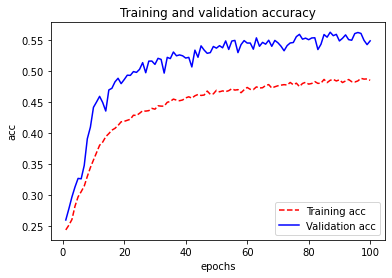

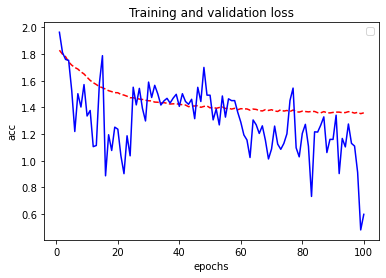

<Figure size 432x288 with 0 Axes>

In [310]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [7]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

In [8]:
face_classifier = face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

classifier =load_model("analisis_emociones_faciales.h5")

class_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

cap = cv2.VideoCapture(0)

In [9]:
cap = cv2.VideoCapture(0)
while True:
    # Grab a single frame of video
    ret, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    faces = face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
    # rect,face,image = face_detector(frame)


        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

        # make a prediction on the ROI, then lookup the class

            preds = classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()